# Solving a PDE using PINNs

$$ \frac{du}{dt} = \nabla \cdot \Sigma \nabla u - a(u-f_d)(u-f_r)(u-f_t) $$

In [1]:
import torch
import torch.nn as nn
! pip install scikit-optimize
import skopt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
!pip install scipy
import scipy.io

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

torch.set_default_dtype(torch.float64)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.6 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [2]:
class PDE_Net_adaptive(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers, hidden_features, use_adaptive_activation=False):
        super(PDE_Net_adaptive, self).__init__()

        self.use_adaptive_activation = use_adaptive_activation

        # Initialize input, hidden, and output layers
        self.linearIn = nn.Linear(in_features, hidden_features)
        self.linear = nn.ModuleList([nn.Linear(hidden_features, hidden_features) for _ in range(hidden_layers)])
        self.linearOut = nn.Linear(hidden_features, out_features)

        # Adaptive activation parameters
        if use_adaptive_activation:
            self.n = 10
            self.ada_act_funs = nn.ParameterList([nn.Parameter(torch.tensor(1. / self.n), requires_grad=True) for _ in range(hidden_layers)])

        # Fixed activation function
        self.act = nn.Tanh()

        # Initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        # He initialization for weights and zeros for biases
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def initial_condition(self, x, y):
      u0 = torch.zeros_like(x)
      mask = (x <= 0.1) & (y >= 0.45) & (y <= 0.55)
      u0[mask] = 1.0
      return u0

    def forward(self, coord):
        # Extract x and y coordinates and ensure they are column vectors
        x_coord = coord[:,0].unsqueeze(1)
        y_coord = coord[:,1].unsqueeze(1)
        t_coord = coord[:,2].unsqueeze(1)

        u0 = self.initial_condition(x_coord, y_coord)

        # Forward pass through the network
        x_out = self.act(self.linearIn(coord))
        for i, layer in enumerate(self.linear):
            if self.use_adaptive_activation:
                x_out = self.act(self.n * self.ada_act_funs[i] * layer(x_out))
            else:
                x_out = self.act(layer(x_out))
        x_out = self.linearOut(x_out)
        time0_mask = t_coord==0
        if any(time0_mask): x_out[time0_mask] = u0[time0_mask]

        return x_out

In [3]:
def rhs_f(u ,params):
  rhs = params['a']*(u - params['fr'])*(u - params['fd'])*(u - params['ft'])
  return rhs

# Defining loss functions for the PDEs

In [4]:
def eval_loss_pde(u_pred, xyt, sigmas):
  gradients = torch.autograd.grad(u_pred, xyt, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

  dudx = gradients[:,0].reshape(-1,1)
  dudy = gradients[:,1].reshape(-1,1)
  dudt = gradients[:,2].reshape(-1,1)

  grad_xx = torch.autograd.grad(dudx, xyt, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:,0]
  grad_yy = torch.autograd.grad(dudy, xyt, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:,1]

  residual_loss = torch.nn.functional.mse_loss(dudt, torch.multiply(sigmas, (grad_xx + grad_yy)).unsqueeze(1) - rhs_f(u_pred, params))

  return residual_loss

def eval_loss_ic(u_pred, u0):
  ic_res = (u_pred - u0)
  loss_ic = (ic_res).pow(2).mean()
  return loss_ic


In [5]:
def compute_relative_l2_error(u_pred, u_exact):
    diff = u_pred - u_exact
    error = torch.sqrt(torch.dot(diff,diff))
    norm_true = torch.sqrt(torch.dot(u_exact,u_exact))
    return (error / norm_true)

Importing the training data

In [6]:
# # !pip install scipy
# import scipy.io
# import numpy as np
# import torch

# # data = scipy.io.loadmat('data.mat')
# # timesteps = data['data']['time'][0,0].flatten()
# # xdata, ydata = np.array(data['data']['vertices'][0,0])
# # t = np.repeat(timesteps, len(xdata)).reshape(-1,len(xdata))
# # usol = np.array(data['data']['u'][0,0])
# parameter_set = {'sigma_h': 9.5298e-4, 'a': 18.515, 'ft': 0.2383, 'fr': 0, 'fd': 1, 'Tf': 1}


# Constructing the collocation points

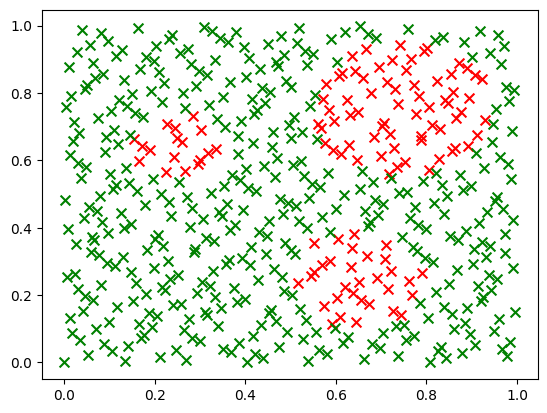

In [7]:


# Number of collocation points in the interior and boundary of the domain
num_samples = 500

# Define the domain and collocation points
space   = [(0., 1.)]*3
sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
all_pts = np.array(sampler.generate(space, num_samples))
train_collocation = all_pts[:, :-1]
params = {'sigma_h': 9.5298e-4, 'a': 18.515, 'ft': 0.2383, 'fr': 0, 'fd': 1, 'Tf': 1}

# Define unhealthy domains
diseased_set = np.array([[0.25,0.65,0.1],[0.75,0.75,0.2],[0.65,0.25,0.15]], dtype=np.float32)
diffusion_mask = np.zeros(train_collocation.shape[0], dtype=bool)
i=0
for center, radius in zip(diseased_set[:,:-1], diseased_set[:,-1]):
  dist = np.linalg.norm(train_collocation - diseased_set[i,:-1], axis=1)
  dist = np.linalg.norm(train_collocation - center, axis=1)
  diffusion_mask = diffusion_mask | (dist <= radius)
  i+=1
diseased_points = train_collocation[diffusion_mask]
healthy_points = train_collocation[~diffusion_mask]

# convert all numpy arrays to Torch
# train_collocation = torch.tensor(train_collocation)

plt.scatter(diseased_points[:,0],diseased_points[:,1], color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(healthy_points[:,0],healthy_points[:,1], color='green', s=50, marker='x', label='Collocation Points')

sigmas = np.ones_like(train_collocation[:,0])*9.5298e-4

train_collocation = torch.tensor(train_collocation)
sigmas = torch.tensor(sigmas)
sigmas.required_grad = False
all_pts = torch.tensor(all_pts)
all_pts.requires_grad = True

# Initial Conditions

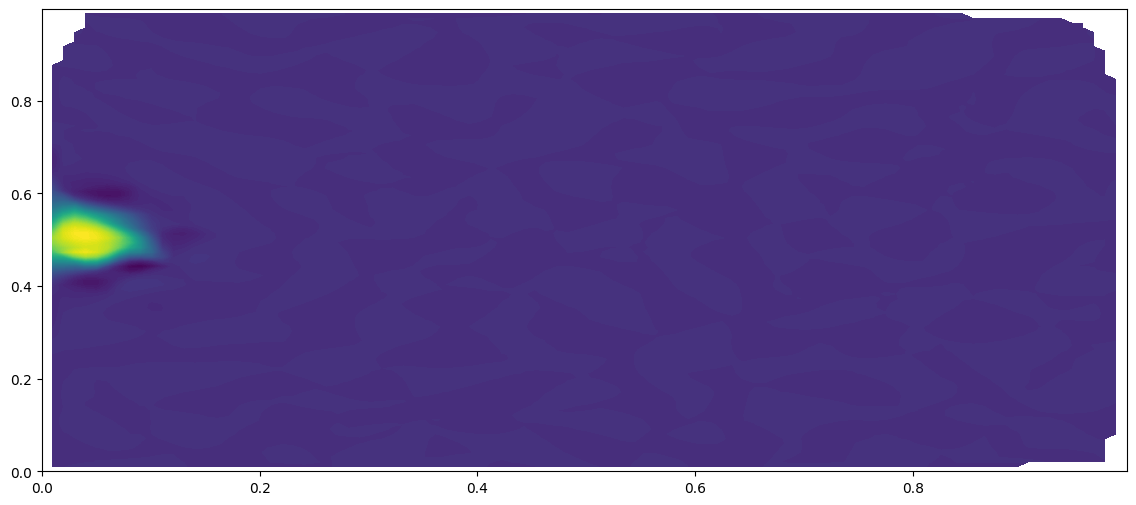

In [8]:


x = [0,0.1]
y = [0.45,0.55]
u0 = np.zeros_like(train_collocation[:,0])
x_mask = (train_collocation[:, 0] > x[0]) & (train_collocation[:, 0] < x[1])
y_mask = (train_collocation[:, 1] > y[0]) & (train_collocation[:, 1] < y[1])

init_mask = x_mask & y_mask
u0[init_mask] = 1.0
u0[~init_mask] = 0.0

xi = np.linspace(min(train_collocation[:,0]), max(train_collocation[:,0]), 100)
yi = np.linspace(min(train_collocation[:,1]), max(train_collocation[:,1]), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((train_collocation[:,0], train_collocation[:,1]), u0, (xi, yi), method='cubic')

fig, ax2 = plt.subplots(figsize=(14, 6))

# Plot the top view (contour plot)
contour = ax2.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.show()


x_init = np.hstack((train_collocation, np.zeros_like(train_collocation[:,0]).reshape(-1,1)))
x_init = torch.Tensor(x_init)
u0 = torch.tensor(u0)

# Define the network and the optimizer, and train the network

In [9]:
model = PDE_Net_adaptive(in_features=3, out_features=1, hidden_layers=4, hidden_features=50, use_adaptive_activation=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), weight_decay=1e-5)

In [10]:
num_epochs = 4000

# Track the best loss
best_loss = np.inf
best_model_path = 'best_model_reg.pth'

In [11]:
def train_model(model, optimizer, num_epochs, inp_pts, x_init, best_model_path):
    best_loss = float('inf')

    # Dictionary to track losses
    loss_history = {'total': [], 'pde': [], 'init': []}
    l2_history = {'train': []}
    w_history = {'pde': [], 'init': []}

    # Define the weights for the loss terms and their optimizer
    w_init = torch.tensor(1.0, requires_grad=True)
    w_pde = torch.tensor(1.0, requires_grad=True)

    for epoch in range(num_epochs):
        inp_pts.requires_grad = True

        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            # Predict in the interior part and calculate PDE loss
            u_pred_train = model(all_pts)
            u_pred_init = model(x_init)
            loss_pde = eval_loss_pde(u_pred_train, inp_pts, sigmas) #eval_loss_pde(u_pred, xyt, sigmas):


            # init loss
            loss_init = eval_loss_ic(u_pred_init, u0)
            # Add all loss components
            total_loss = w_pde*loss_pde + w_init*loss_init

            w_history['init'].append(w_init.item())
            w_history['pde'].append(w_pde.item())

            # Log losses for analysis
            loss_history['pde'].append(loss_pde.item())
            loss_history['init'].append(loss_init.item())
            loss_history['total'].append(total_loss.item())

            if total_loss.requires_grad:
                total_loss.backward()

            return total_loss, loss_pde, loss_init

        # Update the weights using the optimizer
        optimizer.step(closure)

        # After optimizer step, extract the losses again for logging and checks
        total_loss, loss_pde, loss_init = closure()  # This will execute zero_grad, forward, backward again


        # Access data without computing gradients
        with torch.no_grad():
            u_pred_train = model(inp_pts).squeeze()

            # Compute errors
            # l2_train = compute_relative_l2_error(u_pred_train.detach(), u_exact_train)
            # l2_test = compute_relative_l2_error(u_pred_test.detach(), u_exact_test)

            # Store error history
            # l2_history['train'].append(l2_train.item())
            # l2_history['test'].append(l2_test.item())

            # Update w_pde and w_bc using gradient ascent
            w_init += w_init.grad * 0.05  # Manually apply ascent step
            w_pde += w_pde.grad * 0.05
            w_init.grad.zero_()
            w_pde.grad.zero_()

        # Optional print statement every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1:4d}/{num_epochs:4d}], Total Loss: {total_loss:.4e}, PDE Loss : {loss_pde:.4e}, Init Loss: {loss_init:.4e}') # , Train error: {l2_train:.4e}, Test error: {l2_test:.4e}')

        # Save the best model
        if total_loss < best_loss:
            best_loss = total_loss
            torch.save(model.state_dict(), best_model_path)

    return loss_history, l2_history, w_history

In [ ]:
losses_history, l2_history, w_history = train_model(model, optimizer, num_epochs, all_pts, x_init, best_model_path)

Epoch [ 100/20000], Total Loss: 4.9429e+06, PDE Loss : 2.9380e+00, Init Loss: 1.5872e-02
Epoch [ 200/20000], Total Loss: 4.8506e+06, PDE Loss : 2.8831e+00, Init Loss: 1.5872e-02
Epoch [ 300/20000], Total Loss: 4.6967e+06, PDE Loss : 2.7915e+00, Init Loss: 1.5872e-02
Epoch [ 400/20000], Total Loss: 4.4565e+06, PDE Loss : 2.6487e+00, Init Loss: 1.5872e-02
Epoch [ 500/20000], Total Loss: 4.0859e+06, PDE Loss : 2.4284e+00, Init Loss: 1.5872e-02
Epoch [ 600/20000], Total Loss: 3.5236e+06, PDE Loss : 2.0942e+00, Init Loss: 1.5872e-02
Epoch [ 700/20000], Total Loss: 2.7154e+06, PDE Loss : 1.6138e+00, Init Loss: 1.5872e-02
Epoch [ 800/20000], Total Loss: 1.7022e+06, PDE Loss : 1.0117e+00, Init Loss: 1.5872e-02
Epoch [ 900/20000], Total Loss: 7.4842e+05, PDE Loss : 4.4480e-01, Init Loss: 1.5872e-02
Epoch [1000/20000], Total Loss: 1.9707e+05, PDE Loss : 1.1712e-01, Init Loss: 1.5872e-02
Epoch [1100/20000], Total Loss: 2.9790e+04, PDE Loss : 1.7705e-02, Init Loss: 1.5872e-02
Epoch [1200/20000], T

In [ ]:
testdata = scipy.io.loadmat('data.mat')
timesteps = testdata['data']['time'][0,0].flatten()
xdata, ydata = np.array(testdata['data']['vertices'][0,0])
t = np.repeat(timesteps, len(xdata)).reshape(-1,len(xdata))
usol = np.array(testdata['data']['u'][0,0])

np.random.seed(1234)
random_time = np.random.randint(351, size=1)
test_collocation = np.hstack((xdata.reshape(-1,1), ydata.reshape(-1,1)))
utest = usol[:, random_time]
test_collocation = np.hstack((test_collocation, np.repeat(random_time, test_collocation.shape[0]).reshape(-1,1)))
test_collocation = torch.tensor(test_collocation)
test_collocation.requires_grad = True

model.load_state_dict(torch.load(best_model_path))

u_nn_domain = model(test_collocation)

# Create grid coordinates
xi = np.linspace(min(xdata), max(xdata), 100)
yi = np.linspace(min(ydata), max(ydata), 100)
xi, yi = np.meshgrid(xi, yi)

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the contour in the first subplot
ax = axs[0, 0]
zi = griddata((xdata, ydata), utest.squeeze(), (xi, yi), method='cubic')
contour = ax.contourf(xi, yi, zi, levels=100, cmap='viridis')
fig.colorbar(contour, ax=ax)
ax.set_title('Top View')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax = axs[0, 1]
zi1 = griddata((xdata, ydata), u_nn_domain.detach().numpy().squeeze(), (xi, yi), method='cubic')
contour = ax.contourf(xi, yi, zi1, levels=100, cmap='viridis')
fig.colorbar(contour, ax=ax)
ax.set_title('Top View')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

plt.show()